In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
from mpl_toolkits.axes_grid1 import AxesGrid

In [2]:
#Plot code adapted from Andrii Torchylo
def heatmap2d(arr: np.ndarray):
    # define axes grid
    fig = plt.figure(frameon=False,figsize=(12, 8))
    fig.subplots_adjust(top=0.95)
    grid = AxesGrid(
        fig, 111, 
        nrows_ncols=(1, 2),
        axes_pad=0.5,
        cbar_mode='each',
        cbar_location='right',
        cbar_pad=0.1
    )   
    # plot 
    real_image = grid[0].imshow(np.real(arr), cmap='plasma')
    grid[0].set_title("Real Part of matrix, $\Re{(M)}$", fontsize=20)
    imag_image = grid[1].imshow(np.imag(arr), cmap='plasma')
    grid[1].set_title("Imaginary Part of matrix, $\Im{(M)}$", fontsize=20)
    cbar = grid.cbar_axes[0].colorbar(real_image)
    cbar = grid.cbar_axes[1].colorbar(imag_image)
    plt.show()
    

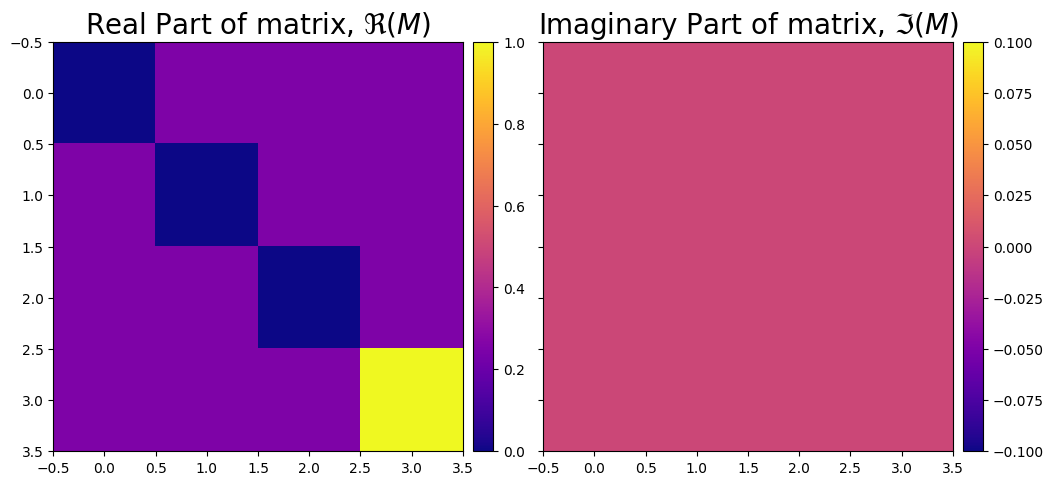

1.0

In [3]:
#Copy code from PSet 1 to generate pauli matrices
pauli = np.array((((0, 1), (1, 0)), ((0, -1j), (1j, 0)), ((1, 0), (0, -1))))
I2 = np.eye(2)
def paulilist(n: int, m: int):
    s=[]
    for i in range(1,m+1):
        mat = pauli[n-1] if i == 1 else I2
        for j in range(1,m):
            if i==j+1:
                mat = np.kron(mat, pauli[n-1])
            else: 
                mat = np.kron(mat, I2)
        s.append(mat)
    return s

gg = np.array([1,0,0,0])
ee = np.array([0,0,0,1])
eg = np.array([0,1,0,0])
ge = np.array([0,0,1,0])
px=paulilist(1,2)
py=paulilist(2,2)
pz=paulilist(3,2)
psi0 = (1/2)*(gg+ee+ge+eg)

#Apply the unitary for free evolution under system hamiltonian to a state psi
def free_evolution(psi, t, delta, V):
    H = -(delta/2)*(pz[0]+pz[1]) + V*((pz[0]+np.eye(4))/2)*((pz[1]+np.eye(4))/2)
    U = scipy.linalg.expm((-1j*H*t))
    return U@psi

#Apply a pi pulse along +x to state psi
def pipulse(psi):
    Rxpi = np.kron(np.array([[0, -1j],[-1j,0]]), np.array([[0, -1j],[-1j,0]]))
    return Rxpi@psi

#Heat map of Hamiltonian
heatmap2d(-(1/2)*(pz[0]+pz[1]) + 1*((pz[0]+1)/2)*((pz[1]+1)/2))

Part A: Ramsey Sequence

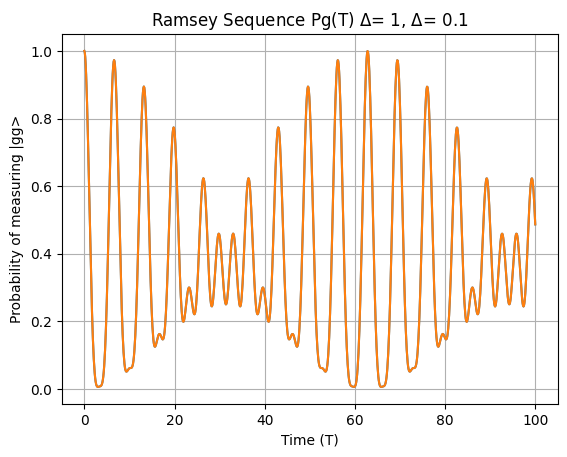

In [4]:
t = np.linspace(0,100,1001)
def ramseySeq(psi0, t, delta, v):
    ramseyPg = []
    for i in t:
        ramseyPg.append(np.abs(np.vdot(psi0, free_evolution(psi0, i, delta, v)))**2)
    return ramseyPg

#Plot Pg for Ramsey sequence with delta>>V
fig, ax  = plt.subplots()
ram1 = ramseySeq(psi0, t,1,0.1)
ax.plot(t, ram1)
ax.set(xlabel='Time (T)', ylabel='Probability of measuring |gg>',
       title='Ramsey Sequence Pg(T) $\Delta$= 1, $\Delta$= 0.1')
ax.grid()
plt.plot(t, ram1)

Part B: Spin Echo Sequence

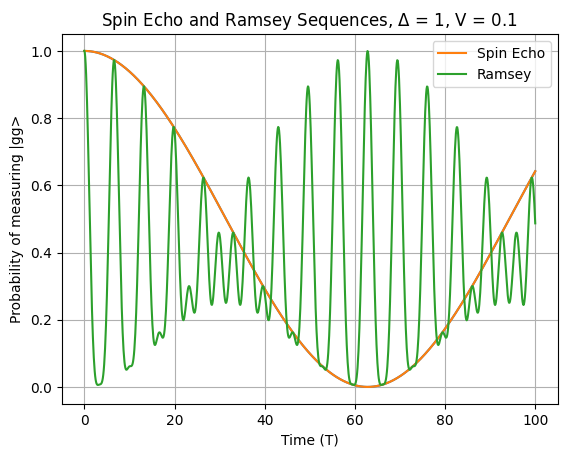

In [5]:
def spinEchoSeq(psi0, t, delta, v):
    spinEchoPg = []
    for i in range(0,len(t)):
        psi = free_evolution(psi0, t[i]/2, delta, v)
        psi = pipulse(psi)
        psi = free_evolution(psi, t[i]/2, delta, v)
        spinEchoPg.append(np.abs(np.vdot(psi0, psi))**2)
    return spinEchoPg
#Plot Pg for Spin Echo sequence with delta>>V
se1 = spinEchoSeq(psi0,t,1,0.1)
fig, ax  = plt.subplots()
line, = ax.plot(t, se1)
ax.set(xlabel='Time (T)', ylabel='Probability of measuring |gg>',
       title='Spin Echo and Ramsey Sequences, $\Delta$ = 1, V = 0.1')
ax.grid()
plt.plot(t, se1, label = 'Spin Echo')
plt.plot(t, ram1, label = 'Ramsey')
plt.legend()

Part D: Shot to Shot Noise in Detuning

In [12]:
def seDetuned(psi0, t, M, delta0, sigma0, v):
    rng = np.random.default_rng(42)
    deltam = rng.normal(delta0, sigma0, M)
    pgn = []
    #for i in range(0,len(t)):
    experiments = []
    for j in range(0,M):
        experiments.append(spinEchoSeq(psi0,t,deltam[j],v))
    return (1/M)*np.sum(experiments, axis=0)

def ramseyDetuned(psi0, t, M, delta0, sigma0, v):
    rng = np.random.default_rng(42)
    deltam = rng.normal(delta0, sigma0, M)
    pgn = []
    #for i in range(0,len(t)):
    experiments = []
    for j in range(0,M):
        experiments.append(ramseySeq(psi0,t,deltam[j],v))
    return (1/M)*np.sum(experiments, axis=0)

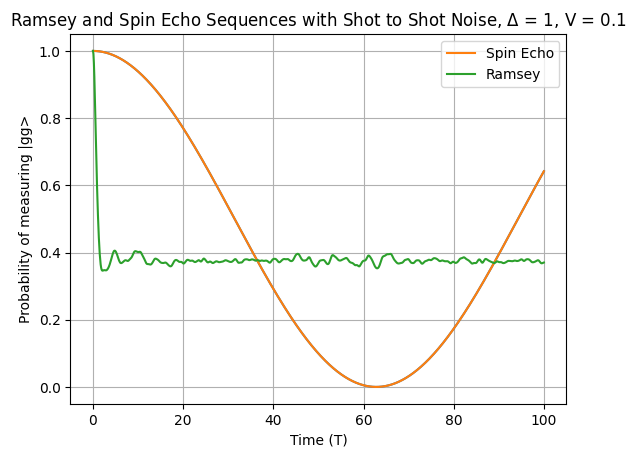

In [11]:

#Delta = 1, Stddev Delta = 1, V = 0.1, M = 1000 trials
ramseyNoisy = ramseyDetuned(psi0, t, 1000, 1, 1, 0.1)
seNoisy = seDetuned(psi0, t, 1000, 1, 1, 0.1)
fig, ax  = plt.subplots()
line, = ax.plot(t, se1)
ax.set(xlabel='Time (T)', ylabel='Probability of measuring |gg>',
       title='Ramsey and Spin Echo Sequences with Shot to Shot Noise, $\Delta$ = 1, V = 0.1')
ax.grid()
plt.plot(t, seNoisy, label = 'Spin Echo')
plt.plot(t, ramseyNoisy, label = 'Ramsey')
plt.legend()


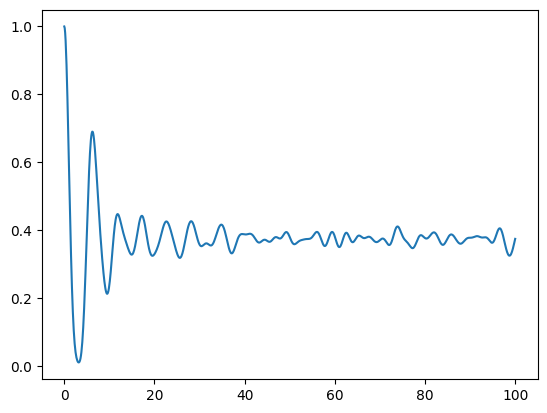

In [16]:
# Delta = 1, Stddev delta = 0.2, V = 0.05,  M = 100
ramseyNoisy2 = ramseyDetuned(psi0, t, 100, 1, 0.2, 0.05)
plt.plot(t, ramseyNoisy2)